<a href="https://colab.research.google.com/github/dequiroz/1MTR53_RobIA/blob/main/graph_slam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?export=view&id=1FsTa2YzWwxY-HBkd2EOXAlkPJ1zpikWv" alt="PUCP" width="150"/>


<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1VBn7nKlruxCPLHH_UuD8B2pkvKP7JLRd" alt="Robótica e Inteligencia Artificial" width="800"/>

</br>

<img src="https://drive.google.com/uc?export=view&id=14u1cJklUZk2NKxCf2t7R-NO7E8BJaMXH" alt="Unidad 3 - Navegación Autónoma" width="800"/>
</p>


#Graph SLAM
* Diego Quiroz Velasquez
* Pontificia Universidad Católica del Perú
* Sección Ingeniería Mecatrónica

---
Este archivo describe el método de Graph Slam aplicado para realizar la localización y mapeo simultaneo en vehículos móbiles.

Se presenta el algoritmo y se procede a mostrar ejemplos con el algoritmo aplicado a un entorno unidimensional seguido por un entorno 2D

<img src="https://drive.google.com/uc?export=view&id=1vgFoFHEKMN0WcAFlKS2hPMg2KuBm3sp9" alt="Material Complementario"/>



#SLAM

Los algoritmos de SLAM (localización y mapeo simultáneos) permiten generar de manera simultánea un modelo del entorno (mapa) y estimar la ubicación del robot mientras se desplaza en dicho entorno. En otras palabras, estos algoritmos proporcionan un método para determinar en tiempo real la posición del robot en el espacio, al mismo tiempo que identifican puntos de referencia como edificios, árboles, rocas y otras características del entorno.

Además de la localización, es necesario construir un modelo del entorno del robot para tener una visión clara de los objetos y puntos de referencia que lo rodean. Esta información permite asegurar que el robot se mantiene en el camino correcto mientras se desplaza. No obstante, al construir el mapa en tiempo real, existe la posibilidad de que el robot pierda la referencia de su ubicación debido a la incertidumbre en su movimiento, ya que no dispone de un mapa previo y debe generarlo conforme avanza.

#Graph SLAM en una dimension

El algoritmo Graph SLAM, en particular, registra la posición inicial del robot, denominada "restricción inicial", y luego recopila múltiples restricciones relativas que vinculan cada posición del robot con su posición anterior, conocidas como "restricciones de movimiento relativo". Por ejemplo, el robot puede observar puntos de referencia en diferentes ubicaciones, lo que representa "restricciones de medición relativas" cada vez que identifica un punto de referencia. Graph SLAM utiliza estas restricciones para calcular la configuración más probable de la trayectoria del robot junto con la ubicación de los puntos de referencia, completando así el proceso de mapeo.

<img src="https://drive.google.com/uc?export=view&id=1w0xqOlf93U95NB4e_Md4A8_bbjOrHUF6" alt="drawing"/>

##Omega y Xi

Para implementar Graph SLAM, se introducen una matriz y un vector, llamados $\Omega$ y $\xi$, respectivamente. La matriz $\Omega$ es cuadrada y está organizada para representar todas las posiciones del robot ($x_i$) y todos los puntos de referencia ($L_i$). Cada vez que se realiza una medición, como cuando el robot se desplaza una distancia $dx$ entre dos posiciones y se puede establecer una relación entre estas dos posiciones, esta información se representa numéricamente dentro de $\Omega$ y $\xi$.

De este modo, las relaciones entre poses y puntos de referencia se van incorporando en las estructuras de $\Omega$ y $\xi$, permitiendo a Graph SLAM construir un modelo del entorno en función de las restricciones observadas.






<img src="https://drive.google.com/uc?export=view&id=1DU5WHUarpF8gaZCci1dDkcXkS3b7ooF2" alt="omega_xi"/>

* Los valores en la matriz se inicializan en cero debido a que no hay conocimiento previo de la ubicación ni del entorno
* Las matrices $\Omega$ y $\xi$ definen las restricciones de Movimiento y Mediciones relativas

Estas restricciones se traducen a valores en las matrices, tal como se muestra en el siguiente ejemplo en el cual se tiene una restricción de *movimiento relativo* que define el movimiento del robot desde la **posición 0** a la **posición 1** con un desplazamiento de **5**

<img src="https://drive.google.com/uc?export=view&id=1JhN1ZSA2Mrlqmd8bnEL2WtzOeQf044Mf" alt="motion_constrain" width=800/>

Para resolver el sistema se debe de considerar la ecuación:

$$\mu = \Omega^{-1} * \xi$$

donde $\mu$ representa el vector de posiciones y ubicaciones de los landmarks identificados

##Ejercicio 1

Implementar un función  ```calcular_mu``` que reciba la posición inicial, y dos cantidades de movimiento para estimar la posición final utilizando las multiplicación de matrices Omega y Xi para el siguiente caso.

$$
\begin{align}
X_0 &= -3\\
X_1 &= X_0 + 5 \\
X_2 &= X_1 + 3
\end{align}$$

In [3]:
import numpy as np

def calcular_mu(posicion_ini: int, move1: int, move2: int):
  matrix_size = 3
  omega = np.zeros((matrix_size, matrix_size))
  xi = np.zeros((matrix_size, 1))

  # Setear posición inicial
  omega[0][0] = 1
  xi[0] = -3

  # Primer movimiento
  omega += [[1., -1, 0.],
            [-1, 1., 0.],
            [0., 0., 0.]]
  xi += [[-5],
         [5],
        [0.]]

  # Segundo movimiento
  omega += [[0, 0., 0.],
            [0, 1., -1.],
            [0, -1, 1.]]
  xi += [[0],
         [-3],
         [3.]]

  mu = np.linalg.inv(omega) @ xi

  return omega, xi, mu

omega, xi, mu = calcular_mu(posicion_ini=-3, move1=5, move2=3)
print(f'{omega = }\n')
print(f'{xi = }\n')
print(f'{mu = }')


omega = array([[ 2., -1.,  0.],
       [-1.,  2., -1.],
       [ 0., -1.,  1.]])

xi = array([[-8.],
       [ 2.],
       [ 3.]])

mu = array([[-3.],
       [ 2.],
       [ 5.]])


A continuación se presenta una segunda versión donde la cantidad de movimientos a realizar es variable.

para ello se aprovecha la propiedad de matrices de numpy de extraer y trabajar con submatrices de forma independiente como se muestra a continuación

In [2]:
# @title Ejemplo de extracción de submatrices con numpy

mtr = np.arange(16).reshape(4,4)
print(f'Matriz inicial: \n{mtr}')

sub_mtr = mtr[0:2,0:2]
print(f'\nSubmatriz 0:2, 0:2 : \n{sub_mtr}')

sub_mtr2 = mtr[1:3,1:3]
print(f'\nSubmatriz 1:3, 1:3 : \n{sub_mtr2}')

mtr[1:3,1:3] = [[0,0],[0,0]]
print(f'\nMatriz modificada: \n{mtr}')

Matriz inicial: 
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]

Submatriz 0:2, 0:2 : 
[[0 1]
 [4 5]]

Submatriz 1:3, 1:3 : 
[[ 5  6]
 [ 9 10]]

Matriz modificada: 
[[ 0  1  2  3]
 [ 4  0  0  7]
 [ 8  0  0 11]
 [12 13 14 15]]


Esto permite realizar la siguiente iteración

```python
for i, movimiento in enumerate(movimientos):
  omega[i:i+2,i:i+2] += [[1., -1],[-1., 1]]
  xi[i:i+2] += [[-movimiento], [movimiento]]
```
Donde se extrae la matriz cuadrada de omega que corresponde a la intersección de coordenadas $x_i$, $x_{i+1}$ de las matrices $\Omega$ y $\xi$ para realizar las operaciones matemáticas correspondientes con cada uno de los movimientos realizados

In [5]:
import numpy as np

def calcular_mu(posicion_ini: int, movimientos: tuple):
  n_movimientos = len(movimientos)
  matrix_size = n_movimientos + 1
  omega = np.zeros((matrix_size, matrix_size))
  xi = np.zeros((matrix_size, 1))

  # Setear posición inicial
  omega[0][0] = 1
  xi[0] = posicion_ini

  # Iterar por los movimientos
  for i, movimiento in enumerate(movimientos):
    omega[i:i+2,i:i+2] += [[1., -1],[-1., 1]]
    xi[i:i+2] += [[-movimiento], [movimiento]]

  mu = np.linalg.inv(omega) @ xi

  return omega, xi, mu

omega, xi, mu = calcular_mu(posicion_ini=-3, movimientos=(5, 3))
print(f'{omega = }\n')
print(f'{xi = }\n')
print(f'{mu = }')

omega = array([[ 2., -1.,  0.],
       [-1.,  2., -1.],
       [ 0., -1.,  1.]])

xi = array([[-8.],
       [ 2.],
       [ 3.]])

mu = array([[-3.],
       [ 2.],
       [ 5.]])


##Ejercicio 2

Modificar el programa anterior para tomar en consideración la medición de la referencia $L_0$ en cada posición del vehículo. Considerar el siguiente esquema

<img src="https://drive.google.com/uc?export=view&id=1BgMcp9ObtI1A6k_NfnqpzLDzX74HXhm1" alt="drawing"/>


con las siguientes restricciones de movimiento y medición

$$
\begin{align}
X_0 &= -3\\
X_1 &= X_0 + 5 \\
X_2 &= X_1 + 3 \\
\\
Z_0 & = 10 \\
Z_1 & = 5 \\
Z_2 & = 2
\end{align}$$

In [11]:
import numpy as np

def calcular_mu(posicion_ini, movimientos, mediciones):
  n_movimientos = len(movimientos)
  n_landmarks = 1
  matrix_size = n_movimientos + n_landmarks + 1
  omega = np.zeros((matrix_size, matrix_size))
  xi = np.zeros((matrix_size, 1))

  # Setear posición inicial
  omega[0][0] = 1
  xi[0] = posicion_ini

  # Iterar por los movimientos
  for i, movimiento in enumerate(movimientos):
      omega[i:i+2,i:i+2] += [[1., -1],[-1., 1]]
      xi[i:i+2] += [[-movimiento], [movimiento]]

  # Iterar por las mediciones
  for i, medicion in enumerate(mediciones):
    omega[np.ix_([i,-1],[i,-1])] += [[1., -1],[-1., 1]]
    xi[np.ix_([i,-1],[0])] += [[-medicion], [medicion]]

  mu = np.linalg.inv(omega) @ xi

  return omega, xi, mu

omega, xi, mu = calcular_mu(posicion_ini=-3, movimientos=(5, 3), mediciones=(10,5,2))
print(f'{omega = }\n')
print(f'{xi = }\n')
print(f'{mu = }')

omega = array([[ 3., -1.,  0., -1.],
       [-1.,  3., -1., -1.],
       [ 0., -1.,  2., -1.],
       [-1., -1., -1.,  3.]])

xi = array([[-18.],
       [ -3.],
       [  1.],
       [ 17.]])

mu = array([[-3.],
       [ 2.],
       [ 5.],
       [ 7.]])


##Ejercicio 3 - Introducción de ruido

Modificar el programa anterior para ver el efecto de cambiar la medición $Z_2$.


In [12]:
omega, xi, mu = calcular_mu(posicion_ini=-3, movimientos=(5, 3), mediciones=(10,5,1))
print(f'{omega = }\n')
print(f'{xi = }\n')
print(f'{mu = }')

omega = array([[ 3., -1.,  0., -1.],
       [-1.,  3., -1., -1.],
       [ 0., -1.,  2., -1.],
       [-1., -1., -1.,  3.]])

xi = array([[-18.],
       [ -3.],
       [  2.],
       [ 16.]])

mu = array([[-3.   ],
       [ 2.125],
       [ 5.5  ],
       [ 6.875]])


## Ejercicio 4 - Multiples landmarks

Modificar la función ```calcular_mu``` para trabajar con multiples landmarks, los cuales se ingresan como diferentes tuples en el parámetro de mediciones



In [13]:
import numpy as np

def calcular_mu(posicion_ini, movimientos, mediciones):
  n_movimientos = len(movimientos)
  n_landmarks = len(mediciones)
  matrix_size = n_movimientos + n_landmarks + 1
  omega = np.zeros((matrix_size, matrix_size))
  xi = np.zeros((matrix_size, 1))

  # Setear posición inicial
  omega[0][0] = 1
  xi[0] = posicion_ini

  # Iterar por los movimientos
  for i, movimiento in enumerate(movimientos):
      omega[i:i+2,i:i+2] += [[1., -1],[-1., 1]]
      xi[i:i+2] += [[-movimiento], [movimiento]]

  # Iterar por las mediciones
  for l, landmark in enumerate(mediciones):
    for i, medicion in enumerate(landmark):
      # Se iteran por la cantidad de landmarks. Si se tiene 5 landmarks, el resultado sería:
      # primera iteración: l = 0, omega[np.ix_([i,-5+0],[i,-5+0]) = omega[np.ix_([i,-5],[i,-5])
      # segunda iteración: l = 1, omega[np.ix_([i,-5+1],[i,-5+1]) = omega[np.ix_([i,-4],[i,-4])
      # De esta forma se logra iterar por todas las columnas de landmarks en las matrices
      # Omega y xi
      omega[np.ix_([i,-n_landmarks+l],[i,-n_landmarks+l])] += [[1., -1],[-1., 1]]
      xi[np.ix_([i,-n_landmarks+l],[0])] += [[-medicion], [medicion]]

  mu = np.linalg.inv(omega) @ xi

  return omega, xi, mu

omega, xi, mu = calcular_mu(-5, movimientos=(2, 6), mediciones=[(7, 5, -1), (10, 8, 2)])
print(f'{omega = }\n')
print(f'{xi = }\n')
print(f'{mu = }')

omega = array([[ 4., -1.,  0., -1., -1.],
       [-1.,  4., -1., -1., -1.],
       [ 0., -1.,  3., -1., -1.],
       [-1., -1., -1.,  3.,  0.],
       [-1., -1., -1.,  0.,  3.]])

xi = array([[-24.],
       [-17.],
       [  5.],
       [ 11.],
       [ 20.]])

mu = array([[-5.],
       [-3.],
       [ 3.],
       [ 2.],
       [ 5.]])


#Graph Slam en 2D

Los ejemplos mostrados han representado el movimiento en una sola dimensión. Para el caso de un mundo en dos dimensiones, las matrices $\Omega$ y $\xi$ deben de considerar estas dos dimensiones, tal que

<img src="https://drive.google.com/uc?export=view&id=1DWTOPeZk6N-NK-auGPEyxH5THQcHCXCs" alt="constrain 2D"/>

Para poder ejecutar esta simulación, vamos a definir las siguientes clases auxiliares

In [16]:
#@title Class World

import random
import math
import matplotlib.pyplot as plt
import seaborn as sns


class World(object):
    def __init__(self, world_size, num_landmarks):
        self.world_size = world_size
        self.num_landmarks = num_landmarks
        self.distance = 20.0
        self.landmarks = None
        self.data = None

    def _make_landmarks(self):
        """ Makes landmarks at random locations in world based on defined number of landmarks """
        self.landmarks = []
        for i in range(self.num_landmarks):
            self.landmarks.append([round(random.random() * self.world_size),
                                   round(random.random() * self.world_size)])

    def _compute_dx_dy(self):
        """ Compute distances in x and y coordinates based on random rotation """
        orientation = random.random() * 2.0 * math.pi
        dx = math.cos(orientation) * self.distance
        dy = math.sin(orientation) * self.distance
        return dx, dy

    def make_data(self, steps, measurement_range, motion_noise, measurement_noise):
        """ Makes the data based on Robot repeated sensing and random movement inside world,
            stops when all landmarks are measured. Data is stored in shape [measurement, [dx, dy]],
            measurement is [landmark_id, x_distance, y_distance], dx and dy represents Robot movement
            at every step """
        print('Generating world...')
        robot = Robot(self.world_size, measurement_range, motion_noise, measurement_noise)
        self._make_landmarks()
        complete = False
        while not complete:
            self.data = []
            seen = [False for _ in range(self.num_landmarks)]
            dx, dy = self._compute_dx_dy()
            for step in range(steps-1):
                measurement = robot.sense(self.landmarks)
                for i in range(len(measurement)):
                    seen[measurement[i][0]] = True
                while not robot.move(dx, dy):
                    dx, dy = self._compute_dx_dy()
                self.data.append([measurement, [dx, dy]])
            complete = (sum(seen) == self.num_landmarks)
        print('\nTrue positions:\n')
        print(f'Landmarks: {self.landmarks}')
        print(robot)

    def display_world(self, robot_positions, landmark_positions):
        """ Plots the estimated Robot movement path and estimated landmark positions in world """
        sns.set_style('dark')
        ax = plt.gca()
        cols, rows = self.world_size + 1, self.world_size + 1
        #ax.set_xticks([x for x in range(1, cols)], minor=True)
        #ax.set_yticks([y for y in range(1, rows)], minor=True)
        plt.ylim((0,self.world_size))
        plt.xlim((0,self.world_size))
        # Plot grid on minor and major axes, major in larger width
        # plt.grid(which='minor', ls='-', lw=1, color='white')
        plt.grid(which='major', ls='-', lw=1.5, color='white')
        # Iterate over robot positions and plot the path and last location
        if len(robot_positions) > 1:
            for i in range(len(robot_positions) - 1):
                dx = robot_positions[i + 1][0] - robot_positions[i][0]
                dy = robot_positions[i + 1][1] - robot_positions[i][1]
                ax.arrow(robot_positions[i][0], robot_positions[i][1], dx, dy, head_width=1.5,
                         length_includes_head=True, color='green')
            ax.text(robot_positions[-1][0], robot_positions[-1][1], 'o', ha='center', va='center',
                    color='r', fontsize=30)
        else:
            ax.text(robot_positions[-1][0], robot_positions[-1][1], 'o', ha='center', va='center',
                    color='r', fontsize=30)
        # Iterate over landmark positions and plot them on map
        for pos in landmark_positions:
            ax.text(pos[0], pos[1], '*', ha='center', va='center', color='purple', fontsize=20)
        plt.rcParams["figure.figsize"] = (8, 4)
        plt.title('Robot and Landmark positions')
        plt.show()

In [17]:
#@title Class Robot

import random


class Robot(object):
    """ Represents the robot with it's move and sense operations in 2D environment """
    def __init__(self, world_size, measurement_range, motion_noise, measurement_noise):
        self.world_size = world_size
        self.measurement_range = measurement_range
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.x = world_size / 2.0
        self.y = world_size / 2.0

    def __repr__(self):
        return f'Robot location: [x = {round(self.x, 3)}, y = {round(self.y, 3)}]'

    @staticmethod
    def random_num():
        """ Return random small number """
        return random.random() * 2.0 - 1.0

    def move(self, dx, dy):
        """ Performs the move operation with added randomness and motion noise,
            returns False if robot leaves the world borders """
        x = self.x + dx + self.random_num() * self.motion_noise
        y = self.y + dy + self.random_num() * self.motion_noise
        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True

    def sense(self, landmarks):
        """ Performs sensing of landmarks in robot environment and calculates distances
            in x and y coordinates from robot to landmarks in measurement range.
            Mesurement shape is: [landmark_id, dx, dy] where dx and dy are distances from
            robot to that landmark """
        measurements = []
        for landmark_id, landmark in enumerate(landmarks):
            dx = landmark[0] - self.x + self.random_num() * self.measurement_noise
            dy = landmark[1] - self.y + self.random_num() * self.measurement_noise
            if abs(dx) <= self.measurement_range and abs(dy) <= self.measurement_range:
                measurements.append([landmark_id, dx, dy])
        return measurements

In [18]:
#@title Class SLAM2D

import numpy as np


class SLAM2D(object):
    def __init__(self, steps, world_size, num_landmarks, measurement_noise, motion_noise):
        self.steps = steps
        self.world_size = world_size
        self.num_landmarks = num_landmarks
        self.measurement_noise = measurement_noise
        self.motion_noise = motion_noise
        self.omega = None
        self.xi = None
        self.mu = None

    def _initialize_constraints(self):
        """ Initializes Omega and Xi with appropriate size and initial position values """
        matrix_size = (self.steps + self.num_landmarks) * 2
        self.omega = np.zeros((matrix_size, matrix_size))
        self.xi = np.zeros((matrix_size, 1))
        # Set initial position
        self.omega[0][0] = 1
        self.omega[1][1] = 1
        self.xi[0:2] = self.world_size / 2

    def _update_omega(self, index1, index2, noise):
        """ Updates Omega matrix on appropriate indexes with added noise """
        if self.omega is not None:
            self.omega[index1, index1] += 1/noise
            self.omega[index1, index2] -= 1/noise
            self.omega[index2, index1] -= 1/noise
            self.omega[index2, index2] += 1/noise
        else:
            raise ValueError('Omega not initialized.')

    def _update_xi(self, index1, index2, value, noise):
        """ Updates Xi vector on appropriate indexes with added noise """
        if self.xi is not None:
            self.xi[index1] -= value/noise
            self.xi[index2] += value/noise
        else:
            raise ValueError('Xi not initialized.')

    def run_slam(self, data):
        """ Runs the SLAM algorithm with measurement and motion updates, calculates the mu vector
            with all estimated Robot movement and landmark locations """
        print('\nRunning SLAM...')
        # Initialize Omega and Xi with start position
        self._initialize_constraints()
        # Get all the motion and measurement iterating over data
        for step in range(len(data)):
            # Get measurement and motion for given step
            measurements = data[step][0]
            motion = data[step][1]
            # Repeat process for x and y dimensions
            for dim in [0, 1]:
                # Calculate indexes based on current step and dimension
                index = 2 * step + dim
                index_2 = index + 2
                # Measurement update:
                for measure in measurements:
                    # Calculate current Landmark index (2*steps is first Landmark index, 2*measure[0] is Landmark Id)
                    landmark_index = 2 * self.steps + 2 * measure[0] + dim
                    # Distance is dx or dy in measurement to Landmark based on current dimension
                    distance = measure[dim + 1]
                    self._update_omega(index, landmark_index, self.measurement_noise)
                    self._update_xi(index, landmark_index, distance, self.measurement_noise)
                # Motion update:
                self._update_omega(index, index_2, self.motion_noise)
                self._update_xi(index, index_2, motion[dim], self.motion_noise)
        # Calculate mu vector with inverse omega matrix and xi vector
        omega_inverse = np.linalg.inv(np.matrix(self.omega))
        self.mu = omega_inverse * self.xi
        print('Done!')

    def get_poses_landmarks(self):
        """ Creates lists of Robot poses and landmarks positions from Mu vector """
        # Create list of poses
        poses = []
        for i in range(self.steps):
            poses.append((self.mu[2*i].item(), self.mu[2*i+1].item()))
        # Create list of landmarks
        landmarks = []
        for i in range(self.num_landmarks):
            landmarks.append((self.mu[2*(self.steps+i)].item(), self.mu[2*(self.steps+i)+1].item()))
        return poses, landmarks

    def show_results(self):
        """ Prints the resulting Robot poses and landmarks positions """
        poses, landmarks = self.get_poses_landmarks()
        print('\nSLAM results:')
        print('Estimated Positions:')
        for i in range(len(poses)):
            print('[' + ', '.join('%.3f' % p for p in poses[i]) + ']')
        print('\n')
        print('Estimated Landmarks:')
        for i in range(len(landmarks)):
            print('[' + ', '.join('%.3f' % land for land in landmarks[i]) + ']')

In [14]:
# Specify needed parameters
world_size = 100
num_landmarks = 10
steps = 20
measurement_range = 50.0
measurement_noise = 2.0
motion_noise = 2.0

In [19]:
# Generate world and show true locations
world = World(world_size, num_landmarks)
world.make_data(steps, measurement_range, motion_noise, measurement_noise)

Generating world...

True positions:

Landmarks: [[66, 38], [9, 22], [45, 34], [21, 78], [22, 57], [27, 1], [93, 94], [9, 70], [82, 23], [46, 82]]
Robot location: [x = 48.898, y = 40.105]


In [20]:
slam = SLAM2D(steps, world_size, num_landmarks, measurement_noise, motion_noise)
slam.run_slam(world.data)
# Print results
slam.show_results()


Running SLAM...
Done!

SLAM results:
Estimated Positions:
[50.000, 50.000]
[33.096, 44.319]
[14.314, 36.810]
[31.546, 48.642]
[47.917, 60.261]
[64.785, 72.756]
[79.302, 83.508]
[94.196, 93.876]
[74.591, 88.642]
[54.509, 83.726]
[35.906, 78.258]
[16.306, 72.430]
[17.976, 92.479]
[9.651, 72.357]
[3.139, 53.028]
[15.370, 36.337]
[27.660, 18.788]
[38.735, 1.348]
[43.567, 20.970]
[48.614, 40.323]


Estimated Landmarks:
[66.336, 37.477]
[9.134, 22.159]
[45.680, 33.656]
[21.227, 78.032]
[22.201, 57.312]
[27.206, 1.543]
[92.840, 93.853]
[9.438, 69.871]
[81.575, 23.000]
[46.528, 81.970]


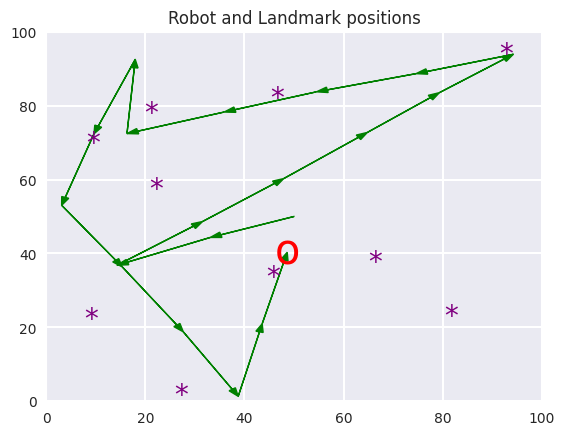

In [21]:
# Get estimated positions from SLAM result and plot them
poses, landmarks = slam.get_poses_landmarks()
world.display_world(poses, landmarks)